# Analyze the performance of the best model
Considering that the logistic regression outperformed the other models, and the version with the network feature generalize better with respect to the one-hot encoding one, we take it as best model (logistic regression with network feature).

In [2]:
import joblib as jl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
)
from sklearn.preprocessing import maxabs_scale
import sklearn as sk

## Load model and Dataset

In [3]:
# Load the models
modelPath = "../models/log_reg_mix.joblib"
model = jl.load(modelPath)

dataPath = "../features/LR_mix_full_data.npz"
data = np.load(dataPath)


# Load the data
path = "../features/"
data_names = ["symptoms", "betweenness", "community_count", "community_size"]

symptoms = np.load(path + data_names[0] + ".npz")
betweenness = np.load(path + data_names[1] + ".npz")
community_count = np.load(path + data_names[2] + ".npz")
community_size = np.load(path + data_names[3] + ".npz")
data_mix = np.concatenate(
    (
        betweenness["X"],
        community_count["X"],
        community_size["X"],
        community_count["y"].reshape(symptoms["y"].shape[0], 1),
    ),
    axis=1,
)

data_norm = maxabs_scale(data_mix[:, :-1])
data = np.concatenate(
    (data_norm, data_mix[:, -1].reshape(data_mix[:, -1].shape[0], 1)), axis=1
)

x = data[:, :-1]
y = data[:, -1].astype(int)

In [4]:
print(y.min())
print(y.max())
print(len(y))
print(len(np.unique(y)))

0
772
246914
748


## Create a 'Mapping' dataframe

In [5]:
diseases_info = pd.read_csv("../../../dataset/diseases_complete_info.csv")
all_diseases = pd.read_csv("../../../dataset/disease_label_mapping.csv")

y_df = pd.DataFrame(y, columns=["Disease_num"])

tmp = pd.merge(y_df, all_diseases, on="Disease_num", how="left")
print(len(tmp["Disease"].unique()))


complete_df = pd.merge(tmp, diseases_info, on="Disease", how="left")
print(len(complete_df["Disease"].unique()))
complete_df = complete_df[["Disease", "Disease_num", "Class"]]


class_mapping = pd.Series(
    complete_df["Class"].values, index=complete_df["Disease_num"]
).to_dict()
name_mapping = pd.Series(
    complete_df["Class"].values, index=complete_df["Disease"]
).to_dict()

complete_df

748
748


,Disease,Disease_num,Class
0,crushing injury,512,3.0
1,crushing injury,512,3.0
2,crushing injury,512,3.0
3,crushing injury,512,3.0
4,crushing injury,512,3.0
...,...,...,...
246909,bursitis,677,1.0
246910,bursitis,677,1.0
246911,bursitis,677,1.0
246912,bursitis,677,1.0


## Map the classes and pedictions

In [6]:
disease_num_series = pd.Series(y)
y_class = disease_num_series.map(class_mapping).values

y_class[np.isnan(y_class)] = 1


pred = model.predict(x)
disease_num_series = pd.Series(pred)
pred_class = disease_num_series.map(class_mapping).values
pred_class[np.isnan(pred_class)] = 1

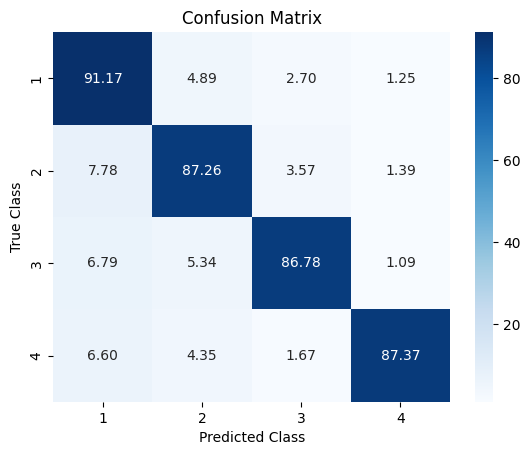

In [7]:
conf_matrix_class = confusion_matrix(y_class, pred_class)

conf_matrix_class_percent = conf_matrix_class / np.sum(conf_matrix_class, axis=1, keepdims=True) * 100

# Plot the confusion matrix with percentages
sns.heatmap(
    conf_matrix_class_percent,
    annot=True,
    fmt=".2f",  # Format as percentage with two decimal places
    cmap="Blues",
    cbar=True,
    xticklabels=np.unique(y_class).astype(int),
    yticklabels=np.unique(y_class).astype(int),
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

## Get accuracy for each class

In [8]:
conf_matrix = confusion_matrix(y, pred)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)


accuracies = [conf_matrix_percent[i, i] for i in range(len(conf_matrix_percent))]

accuracies_df = pd.DataFrame({"Disease_num": np.unique(y), "Accuracy": accuracies})

## It's impossible to visualize the whole confusion matrix, so we try a different approach

,Disease_num,Disease,precision,recall,f1-score,Accuracy
0,0,fracture of the pelvis,0.825145,0.842183,0.833577,0.842183
1,1,testicular cancer,0.857143,1.000000,0.923077,1.000000
2,2,injury to the arm,0.938998,0.966368,0.952486,0.966368
3,3,heat stroke,0.724138,0.965517,0.827586,0.965517
4,4,sporotrichosis,0.200000,1.000000,0.333333,1.000000
...,...,...,...,...,...,...
743,768,induced abortion,0.995356,0.941435,0.967645,0.941435
744,769,pelvic inflammatory disease,0.897281,0.889222,0.893233,0.889222
745,770,thyroid nodule,0.806452,0.937500,0.867052,0.937500
746,771,diverticulitis,0.307692,0.800000,0.444444,0.800000


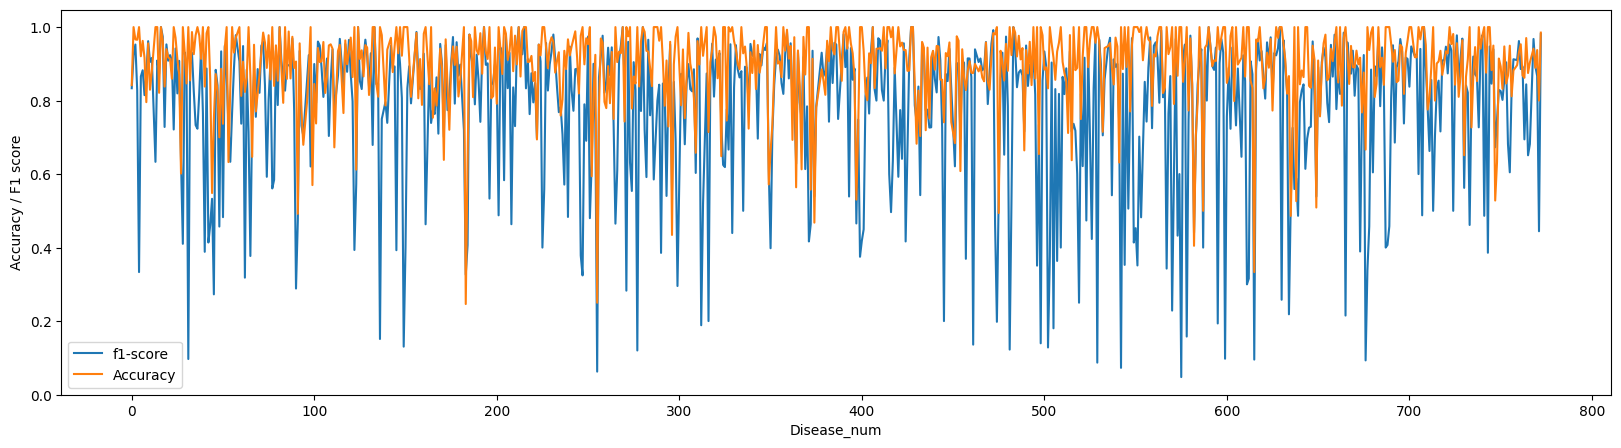

In [9]:
all_diseases = pd.read_csv("../../../dataset/disease_label_mapping.csv")

report = classification_report(y, pred, output_dict=True)

report_df = pd.DataFrame(report)
report_df = report_df.drop(columns=["accuracy", "macro avg", "weighted avg"])


report_df = report_df.transpose()
report_df["Disease_num"] = report_df.index

report_df = report_df.sort_values(by="f1-score", ascending=False)
report_df = report_df.reset_index()


# Convert 'Disease_num' column in complete_df to int64
report_df["Disease_num"] = report_df["Disease_num"].astype(int)


report_df = pd.merge(report_df, complete_df, on="Disease_num")
report_df = pd.merge(report_df, accuracies_df, on="Disease_num")

report_df = report_df.drop(columns=["index", "support", "Class"])
report_df = report_df.groupby(["Disease_num", "Disease"]).mean()
report_df = report_df.reset_index()
report_df.plot(
    kind="line", x="Disease_num", y=["f1-score","Accuracy"],ylabel="Accuracy / F1 score", figsize=(20, 5))
report_df

## Get diseases with the highest accuracy

In [10]:
report_df=report_df.sort_values(by="Accuracy", ascending=False)
best_diseases=report_df[['Disease_num','Disease','Accuracy','f1-score']].head(10)
best_diseases.sort_values(by="f1-score", ascending=False)

,Disease_num,Disease,Accuracy,f1-score
15,16,vaginitis,1.0,1.000000
410,427,reactive arthritis,1.0,1.000000
1,1,testicular cancer,1.0,0.923077
13,14,urinary tract obstruction,1.0,0.909091
38,39,breast cyst,1.0,0.765957
22,23,friedrich ataxia,1.0,0.721311
12,13,perirectal infection,1.0,0.633333
27,28,urethral valves,1.0,0.410256
4,4,sporotrichosis,1.0,0.333333
30,31,subarachnoid hemorrhage,1.0,0.096774


## Get the diseases with the lowest accuracy

In [11]:
worst_diseases = report_df[["Disease_num", "Disease", "Accuracy", "f1-score"]].tail(10)
worst_diseases

,Disease_num,Disease,Accuracy,f1-score
567,587,premature ventricular contractions (pvcs),0.500000,0.400000
456,475,fracture of the jaw,0.494083,0.547541
89,91,hemiplegia,0.491954,0.473976
613,635,omphalitis,0.486279,0.523641
361,374,poisoning due to antimicrobial drugs,0.467849,0.539642
285,296,open wound of the mouth,0.434379,0.556134
562,582,acute otitis media,0.404840,0.440455
593,615,blepharitis,0.333333,0.095238
245,255,otitis media,0.250000,0.062500
173,183,bladder cancer,0.246377,0.326199


### Get the diseases mispredicted as 'bladder cancer'

173


<Axes: title={'center': 'Bladder cancer missclassified samples'}, xlabel='Disease', ylabel='Percentage of missclassified samples'>

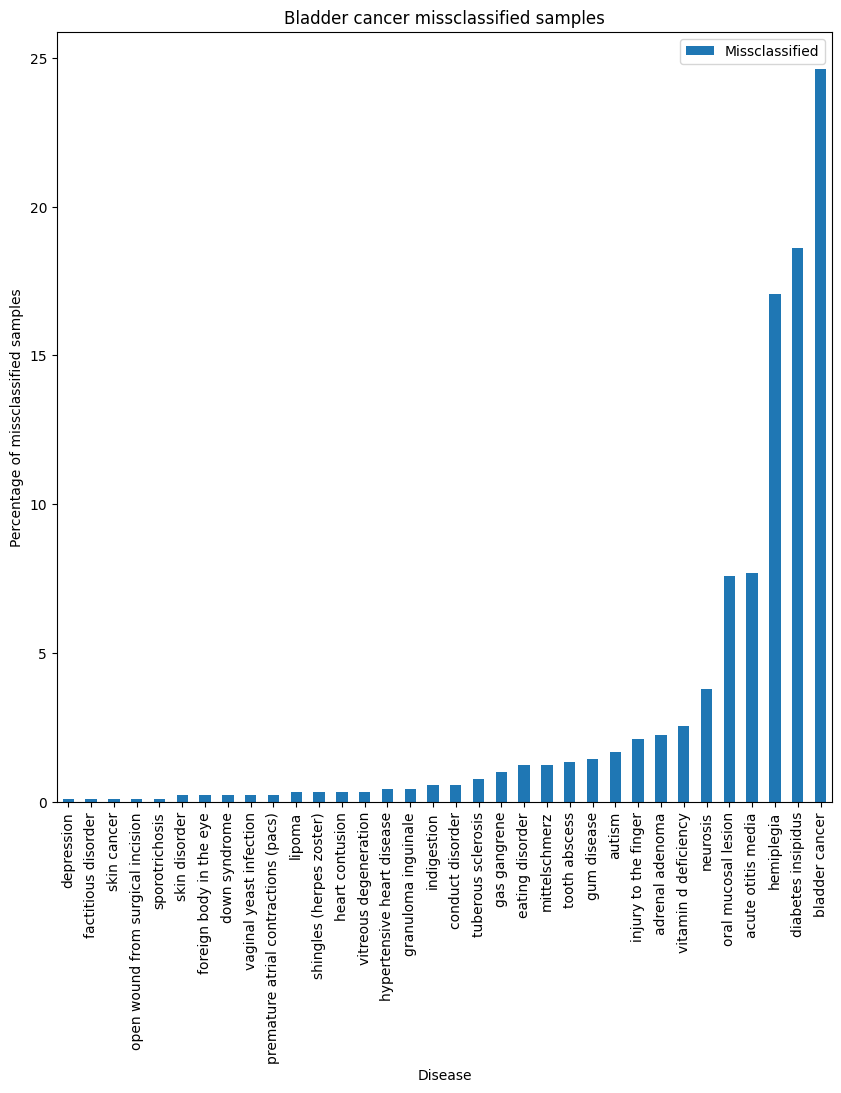

In [17]:
order = np.array(np.unique(y))
pos_conf_matrix = np.where(
    order
    == worst_diseases[worst_diseases["Disease"] == "bladder cancer"][
        "Disease_num"
    ].values[0]
)[0][0]

pos_conf_matrix

missclassified = conf_matrix_percent[pos_conf_matrix, :]

bladder_cancer_df = pd.DataFrame(
    {"Disease_num": order, "Missclassified": missclassified}
)
bladder_cancer_df = pd.merge(bladder_cancer_df, complete_df, on="Disease_num")
bladder_cancer_df = bladder_cancer_df[bladder_cancer_df["Missclassified"] > 0]
print(pos_conf_matrix)
bladder_cancer_df = (
    bladder_cancer_df[["Disease", "Missclassified"]].groupby("Disease").mean()
)
bladder_cancer_df["Missclassified"] = bladder_cancer_df["Missclassified"] * 100
bladder_cancer_df.sort_values(by="Missclassified", ascending=True).plot(
    kind="bar", figsize=(10, 10),ylabel="Percentage of missclassified samples", title="Bladder cancer missclassified samples",xlabel="Disease"
)
